<a href="https://colab.research.google.com/github/simi-asher/LLR-perception-assist/blob/master/parameter-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade -q gspread
!pip install -q grpcio==1.24.3
!pip install -q google-auth==1.6.3
#!pip install -q tensorflow==2.0.0
!pip install np_utils
!pip install talos


In [ ]:
import tensorflow as tf
import tensorflow.keras
print(tf.__version__)
print(tensorflow.keras.__version__)

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [ ]:
import os
import talos as ta
import numpy as np
import pandas as pd
import shutil
#import tensorflow as tf
#from tensorflow.contrib import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


Using TensorFlow backend.


In [ ]:
#read sheets and make dataframes
from google.colab import auth
auth.authenticate_user()

import gspread
import pandas as pd
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet1 = gc.open('sit_jan_38').sheet1

# get_all_values gives a list of rows.
rows1 = worksheet1.get_all_values()
# Convert to a DataFrame and render.
df1 = pd.DataFrame(rows1)
df1.columns = df1.iloc[0]
df1 = df1.iloc[1:].astype(float)
df1.Unsafe= df1.Unsafe.astype(int)
df1.Safe= df1.Safe.astype(int)
                
print(df1.shape)

worksheet3 = gc.open('sit_feb_38').sheet1

# get_all_values gives a list of rows.
rows3 = worksheet3.get_all_values()
# Convert to a DataFrame and render.
df_feb = pd.DataFrame(rows3)
df_feb.columns = df_feb.iloc[0]
df_feb = df_feb.iloc[1:].astype(float)
df_feb.Unsafe= df_feb.Unsafe.astype(int)
df_feb.Safe= df_feb.Safe.astype(int)
df1=df1.append(df_feb,)                
print(df1.shape)

worksheet2 = gc.open('feb_test_sit_37').sheet1

# get_all_values gives a list of rows.
rows2 = worksheet2.get_all_values()
# Convert to a DataFrame and render.
df2 = pd.DataFrame(rows2)
df2.columns = df2.iloc[0]
df2 = df2.iloc[1:].astype(float)
df2.Unsafe= df2.Unsafe.astype(int)
#df2.Safe= df2.Safe.astype(int)
print(df1.shape,df2.shape)

(28415, 38)
(49456, 38)
(49456, 38) (104399, 37)


In [ ]:
#select K best columns
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler


X1 = df1.iloc[:,0:36].astype(float) # sensor data
Y_train = df1.iloc[:,36:37].astype(int) # labels
X2 = df2.iloc[:,0:36].astype(float) # sensor data
Y_test = df2.iloc[:,36:37].astype(int) # labels

scaler_x = StandardScaler().fit(X1)
X1_scaled = scaler_x.transform(X1)
X2_scaled = scaler_x.transform(X2)

bestfeatures = SelectKBest(score_func=f_classif, k=10) 
fit = bestfeatures.fit(X2_scaled,Y_test) 
cols = bestfeatures.get_support(indices=True)

print(cols)
dfscores = pd.DataFrame(fit.scores_) 
dfcolumns = pd.DataFrame(X2.columns) 


#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1) 
featureScores.columns = ['Specs','Score'] #naming the dataframe columns 
print(featureScores.nlargest(10,'Score')) #print 10 best features

[ 8  9 10 11 12 13 21 26 30 34]
                 Specs         Score
30             Pitch 1  65100.317108
11              Heel Y  60019.744118
13              Foot Y  59268.590021
9                Toe Y  50034.156383
34  Height of obstacle  41419.676929
21     Upp Thigh vel Y  41036.545721
12              Foot X  33410.145468
10              Heel X  33126.068376
8                Toe X  32594.908829
26           Encoder 4  19945.693450


In [ ]:
#to balance data/remove some points from dataframe. Currently commented out
l=[]
print(df1.groupby(['Unsafe']).count(),df2.groupby(['Unsafe']).count())
df3=df1
df4=df2
#for asc
# temp=df2[(df2['Unsafe'] == 0)].iloc[::2]
# l.append(temp)
# l.append(df2[(df2['Unsafe'] == 1)])
# df4 = pd.concat(l, ignore_index=True)
#for sit
temp=df2[(df2['Unsafe'] == 1)].iloc[::2]
l.append(temp)
l.append(df2[(df2['Unsafe'] == 0)])
df4 = pd.concat(l, ignore_index=True)
df4=df4.iloc[::3]


print(df3.groupby(['Unsafe']).count(),df4.groupby(['Unsafe']).count())
X_train = df3.iloc[:,cols]
X_test=df4.iloc[:,cols]
Y_train=df3.iloc[:,36:37]
Y_test=df4.iloc[:,36:37]
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

0       EMG 1  EMG 2  EMG 3  ...  Height of obstacle  Depth of Obstacle   Safe
Unsafe                       ...                                              
0       21475  21475  21475  ...               21475              21475  21475
1       27981  27981  27981  ...               27981              27981  27981

[2 rows x 37 columns] 0       EMG 1  EMG 2  ...  Height of obstacle  Depth of Obstacle
Unsafe                ...                                       
0       36722  36722  ...               36722              36722
1       67677  67677  ...               67677              67677

[2 rows x 36 columns]
0       EMG 1  EMG 2  EMG 3  ...  Height of obstacle  Depth of Obstacle   Safe
Unsafe                       ...                                              
0       21475  21475  21475  ...               21475              21475  21475
1       27981  27981  27981  ...               27981              27981  27981

[2 rows x 37 columns] 0       EMG 1  EMG 2  ...  Height of ob

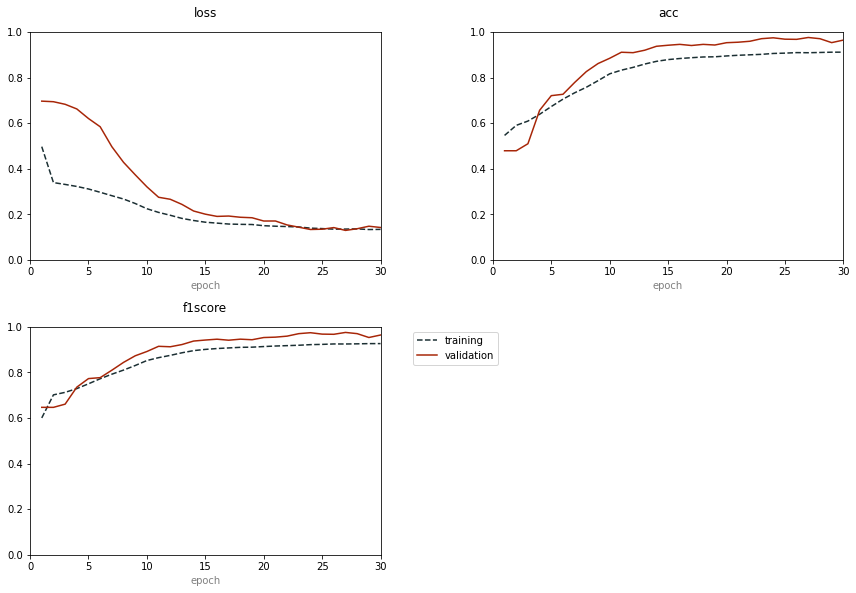

100%|██████████| 36/36 [25:11<00:00, 43.97s/it]


In [ ]:
#from keras import models
#from keras import layers
import talos
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation
from tensorflow.keras.layers import LeakyReLU,PReLU
from talos.model.early_stopper import early_stopper


# (1) Define dict of parameters to try
p = {'first_neuron':[10,15,20],
     'hidden_neuron':[5,10,15],
     'hidden_layers':[0,1,2,3],
     'batch_size': [128],
     'optimizer': ['adam'],
     'kernel_initializer': ['he_uniform'], 
     'epochs': [30],
     'dropout': [0.5],
     'activation': ['relu'],
     'last_activation': ['sigmoid']}
class_weight = {0:27981/49456, #desc 9499/19626, #asc comb 9953/20764, #asc jan 6924/15142,
                1: 21475/49456 #10127/19626, #10811/20764 #8218/15142
                }

# (2) create a function which constructs a compiled keras model object
def numerai_model(x_train, y_train, x_val, y_val, params):
    print(params)

    model = Sequential()
    
    
    ## initial layer
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    kernel_initializer = params['kernel_initializer'] ))
    model.add(Dropout(params['dropout']))
    if params['activation'] == 'leakyrelu':
      model.add(LeakyReLU(alpha=0.1)),
      #x = keras.layers.LeakyReLU(alpha = 0.1)(x)
    else:
      model.add(Activation(params['activation']))
    
    ## hidden layers
    for i in range(params['hidden_layers']):
        print (f"adding layer {i+1}")
        model.add(Dense(params['hidden_neuron'],
                    kernel_initializer=params['kernel_initializer']))
        model.add(Dropout(params['dropout']))
        if params['activation'] == 'leakyrelu':
          model.add(LeakyReLU(alpha=0.1)),
          #x = tensorflow.keras.layers.LeakyReLU(alpha = 0.1)(x)
        else:
          model.add(Activation(params['activation']))
          #x = Activation(params['activation'])(x)
           
    
    ## final layer
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=params['optimizer'],
                  metrics=['acc', ta.utils.metrics.f1score])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        callbacks=[ta.utils.live()],class_weight=class_weight, #,ta.live(),
                        verbose=0)
    return history, model

# (3) Run a "Scan" using the params and function created above

t = ta.Scan(x=X_train.values,
            y=Y_train.values,
            model=numerai_model,
            x_val=X_test.values,
            y_val=Y_test.values,
            params=p,
            fraction_limit=1.0,
            experiment_name='numerai_example'
            )

In [ ]:
analyze_object = talos.Analyze(t)
print("rounds",analyze_object.rounds())

# get the highest result for any metric
print(analyze_object.high('val_acc'))

print(analyze_object.high('val_f1score'))
# get the round with the best result
print(analyze_object.rounds2high('val_acc'))
print(analyze_object.rounds2high('val_f1score'))
# get the best paramaters
print(analyze_object.best_params('val_acc', ['acc', 'val_acc', 'val_loss']))

# get correlation for hyperparameters against a metric
print(analyze_object.correlate('val_loss', ['acc', 'loss', 'val_loss']))

rounds 36
0.9825262427330017
0.9817996621131897
21
21
[[30 0.9817996621131897 'relu' 'adam' 'he_uniform' 20 0.5 2 30 10
  'sigmoid' 0.15115707766099565 0.9003344178199768 128 0]
 [30 0.979133129119873 'relu' 'adam' 'he_uniform' 15 0.5 1 30 15
  'sigmoid' 0.14326447193019407 0.9092711806297302 128 1]
 [30 0.9782654047012329 'relu' 'adam' 'he_uniform' 10 0.5 1 30 15
  'sigmoid' 0.18084361534583765 0.8759992718696594 128 2]
 [30 0.977943480014801 'relu' 'adam' 'he_uniform' 15 0.5 1 30 10
  'sigmoid' 0.1341857701848526 0.9146511554718018 128 3]
 [30 0.9768838286399841 'relu' 'adam' 'he_uniform' 20 0.5 2 30 15
  'sigmoid' 0.13377537192437533 0.9182909727096558 128 4]
 [30 0.9755459427833557 'relu' 'adam' 'he_uniform' 20 0.5 1 30 5
  'sigmoid' 0.16916637908907162 0.868446946144104 128 5]
 [30 0.9738131165504456 'relu' 'adam' 'he_uniform' 15 0.5 2 30 10
  'sigmoid' 0.15409174226935493 0.9046758413314819 128 6]
 [30 0.968980610370636 'relu' 'adam' 'he_uniform' 20 0.5 1 30 15
  'sigmoid' 0.1252

In [ ]:
reporting = ta.Reporting(t)
print(reporting.data.iloc[10])

round_epochs                  30
loss                    0.180844
acc                     0.850372
f1score                 0.875999
val_loss                0.131222
val_acc                 0.979338
val_f1score             0.978265
activation                  relu
batch_size                   128
dropout                      0.5
epochs                        30
first_neuron                  10
hidden_layers                  1
hidden_neuron                 15
kernel_initializer    he_uniform
last_activation          sigmoid
optimizer                   adam
NaN                           10
Name: 10, dtype: object


findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


TypeError: ignored

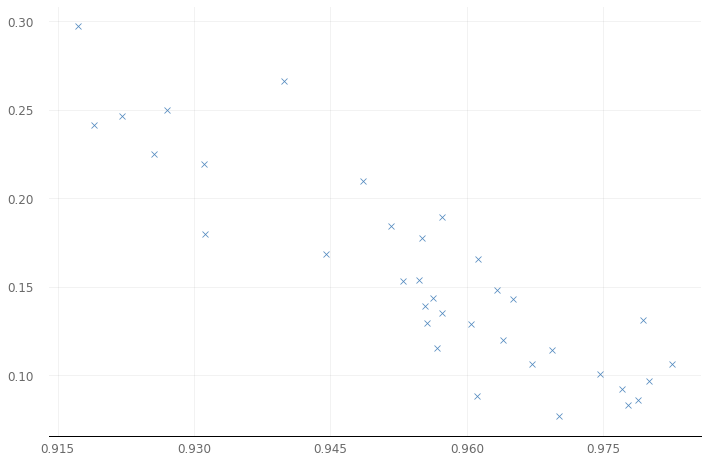

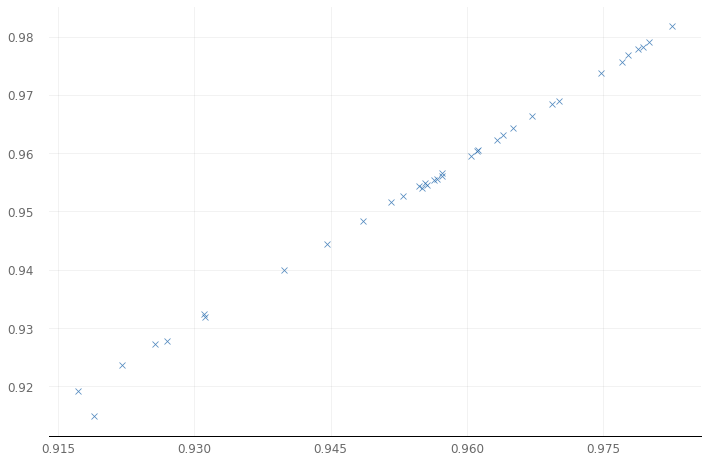

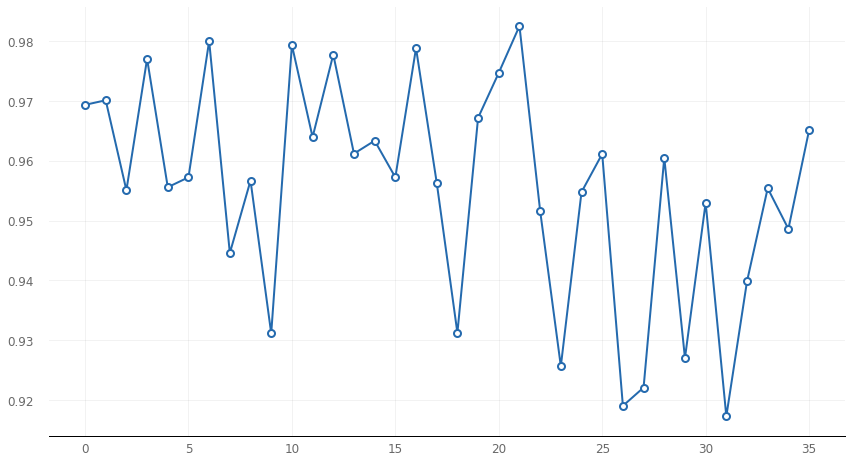

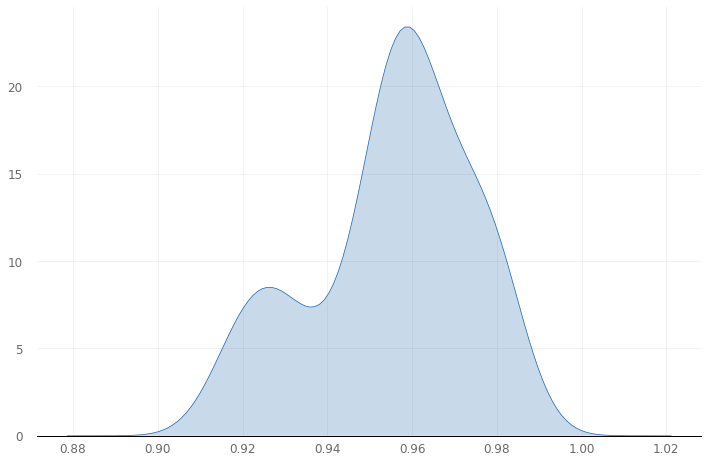

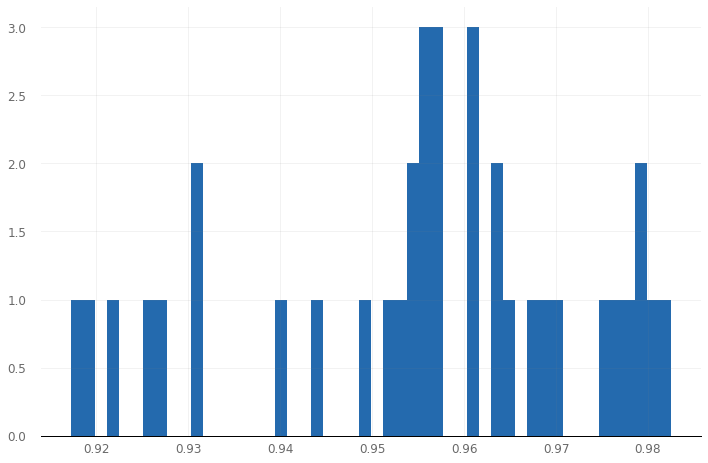

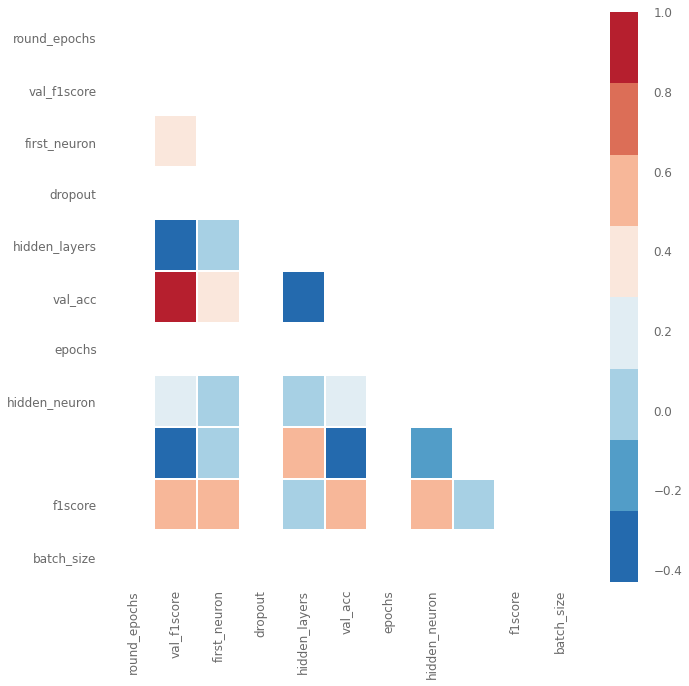

In [ ]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_acc', 'val_loss')
analyze_object.plot_regs('val_acc', 'val_f1score')
# line plot
analyze_object.plot_line('val_acc')

# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_acc')

# a simple histogram
analyze_object.plot_hist('val_acc', bins=50)

# heatmap correlation
analyze_object.plot_corr('val_acc', ['acc', 'loss', 'val_loss'])

# a four dimensional bar grid
analyze_object.plot_bars('val_loss', 'val_acc')